## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [2]:
!pip install nlp

In [3]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.18.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [4]:
!pip install datasets
from datasets import load_dataset
dataset = load_dataset("dair-ai/emotion", "split")
#dataset = nlp.load_dataset('emotion')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [7]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [data.features["label"].int2str(x["label"]) for x in data] # Convert numbers to text
  return tweets, labels

In [8]:
tweets, labels = get_tweet(train)

In [9]:
tweets[1], labels[1]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'sadness')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer


In [11]:
tokenizer = Tokenizer(num_words=10000, oov_token="<UNK>")
tokenizer.fit_on_texts(tweets)

In [12]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [13]:
tweets[0]

'i didnt feel humiliated'

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

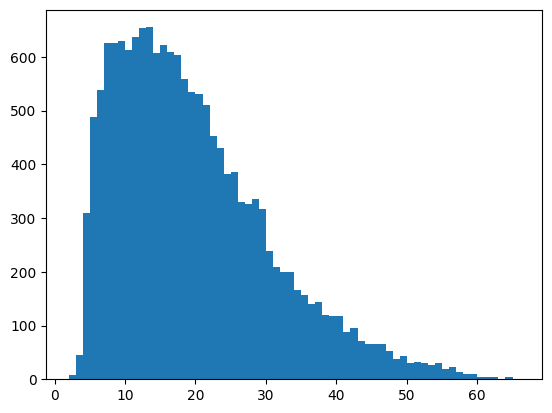

In [14]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [15]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded_sequences = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded_sequences

In [17]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [18]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [23]:
classes = set(labels)
print(classes)

{'sadness', 'anger', 'love', 'joy', 'surprise', 'fear'}


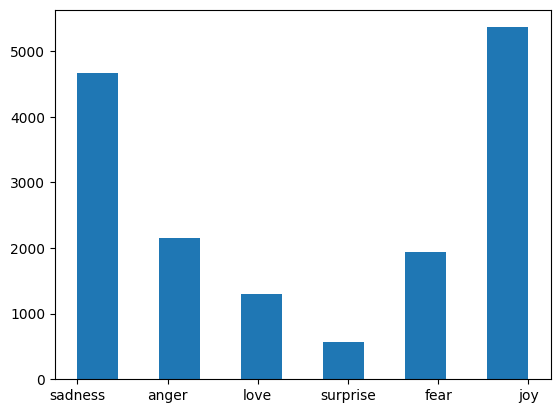

In [24]:
plt.hist(labels, bins=11)
plt.show()

In [25]:
class_to_index = dict((c,i) for i,c in enumerate(classes))
index_to_class = dict((v,k) for k,v in class_to_index.items())

In [26]:
class_to_index

{'sadness': 0, 'anger': 1, 'love': 2, 'joy': 3, 'surprise': 4, 'fear': 5}

In [27]:
index_to_class

{0: 'sadness', 1: 'anger', 2: 'love', 3: 'joy', 4: 'surprise', 5: 'fear'}

In [28]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [29]:
train_labels = names_to_ids(labels)
print(train_labels[0])

0


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [49]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16,input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
    ])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [50]:
model.build(input_shape=(None, maxlen))
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, 50, 16)              │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_16 (Bidirectional)     │ (None, 50, 40)              │           5,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_17 (Bidirectional)     │ (None, 40)                  │           9,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 6)                   │             246 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 175,926 (687.21 KB)

 Trainable params: 175,926 (687.21 KB)

 Non-trainable params: 0 (0.00 B)

## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [51]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [52]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon',
 np.int64(0))

In [53]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - accuracy: 0.3635 - loss: 1.5537 - val_accuracy: 0.6925 - val_loss: 0.8341
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 58ms/step - accuracy: 0.7326 - loss: 0.7038 - val_accuracy: 0.7630 - val_loss: 0.6399
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - accuracy: 0.8632 - loss: 0.4048 - val_accuracy: 0.8570 - val_loss: 0.4220
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - accuracy: 0.9360 - loss: 0.2043 - val_accuracy: 0.8800 - val_loss: 0.3865
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 30s 60ms/step - accuracy: 0.9546 - loss: 0.1422 - val_accuracy: 0.8705 - val_loss: 0.4504
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 57ms/step - accuracy: 0.9700 - loss: 0.1031 - val_accuracy: 0.8850 - val_loss: 0.3722
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 60ms/step - accuracy: 0.9744 - loss: 0.0778 - val_accuracy: 0.8925 - val_loss: 0.4006
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - accuracy: 0.9814 - loss: 0.0569 - 

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

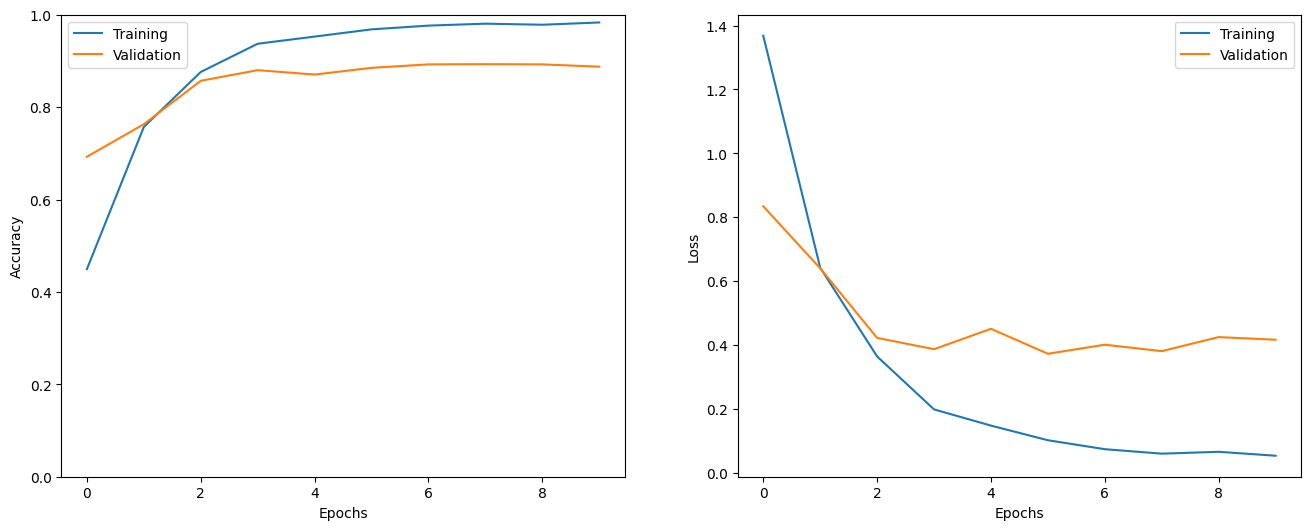

In [55]:
show_history(h)

In [56]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [57]:
_ = model.evaluate(test_seq, test_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8889 - loss: 0.4042


In [61]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i]  )
print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)

Sentence: i could maybe get away with simpler folk melodies on some of the songs something fairly predictable but if its just me and a guitar it would end up feeling dull
Emotion: sadness
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted Emotion: sadness


In [70]:
preds = model.predict(test_seq)   # Get probability scores
preds = np.argmax(preds, axis=1)  # Convert to class labels

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


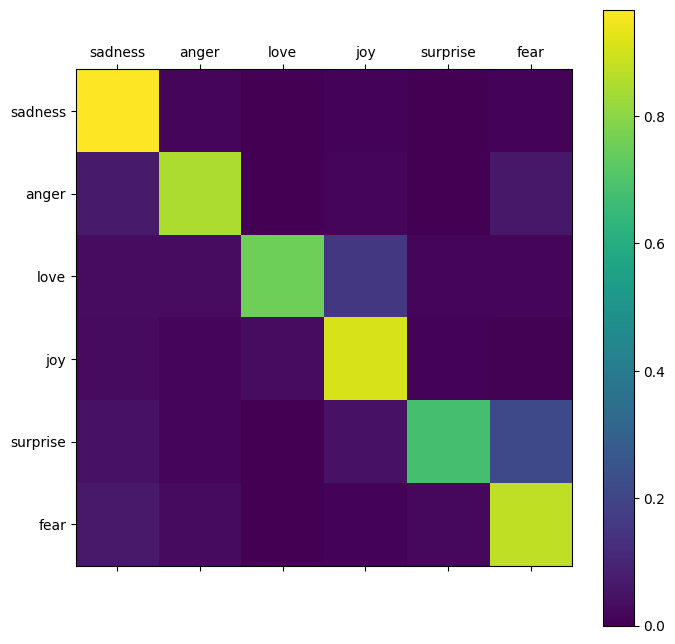

In [71]:
show_confusion_matrix(test_labels, preds, list(classes))